In [33]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy
# %pip install scikit-learn
# %pip install xgboost

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, KernelPCA

In [35]:
class Flags:
    DRAW_PLOTS = False
    KEEP_TAXONOMY = False
    OMIT_ABSENT = True
    PRINT_FOLDS = False
    REDUCE_PCA = False
    SAVE_PLOTS = False
    SEED = 0

In [36]:
class Global:
    binary_target = None
    data = None
    folds = None
    kfold = None

In [37]:
class Models:
    random_forest = RandomForestClassifier( n_estimators = 200, criterion = 'gini', random_state = Flags.SEED, max_features = 'sqrt' )
    xgboost = XGBClassifier( random_state = Flags.SEED, n_jobs = 4 )
    lda = LinearDiscriminantAnalysis()

### Visualization and Data Exploration

In [38]:
Global.data = pd.read_csv( '../data/data_1.csv' )
print( 'Bacteria:', Global.data.shape[0] )
print( 'Patients:', Global.data.shape[1] )
Global.data.head()

Bacteria: 5619
Patients: 61


,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473


In [39]:
Global.data = Global.data.drop( 'Taxonomy', axis = 1 ).T.rename_axis( 'Patient', axis = 1 )
if Flags.KEEP_TAXONOMY:
    Global.data.columns = pd.read_csv( '../data/data_1.csv' )[ 'Taxonomy' ]
if Flags.OMIT_ABSENT:
    Global.data.drop( columns = Global.data.columns[ Global.data.sum() == 0 ], inplace = True )
Global.data.head()

Patient,0,1,2,3,4,5,6,7,8,9,...,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,1,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [40]:
def define_binary_target():
    target = Global.data.index.to_list()
    Global.binary_target = np.array( [ 0 if t.startswith( 'A' ) else 1 for t in target ] )
    Global.binary_target

define_binary_target()
print( Global.binary_target )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [41]:
def most_correlated_taxonomy( width ):
    x = pd.concat( [ Global.data[:10], Global.data[30:40] ] )
    x = x.iloc[:, ::20]
    corrm = x.corr()
    for i in corrm:
        sorted = corrm[i].sort_values( ascending = False, key = lambda x: abs(x) )
        print( i )
        print( { sorted.index[j]: sorted[j].item() for j in range( 1, width+1 ) } )
        print()

if Flags.KEEP_TAXONOMY:
    most_correlated_taxonomy( 2 )

In [42]:
def draw_boxplot():
    plt.figure( figsize = ( 150, 10 ) )
    plt.boxplot( Global.data.iloc[ :, :100 ] )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/boxplot.png", bbox_inches = 'tight', dpi = 100 )

if Flags.DRAW_PLOTS:
    draw_boxplot()

In [43]:
def draw_heatmaps( samples: int, size: int, filter: float ):
    data_subset = Global.data.sample( axis = 1, n = samples )
    a_group = data_subset[:30]
    b_group = data_subset[30:]
    a_corr = a_group.corr()
    a_filtered_corr = a_corr[ a_corr.abs() >= filter ]
    b_corr = b_group.corr()
    b_filtered_corr = b_corr[ b_corr.abs() >= filter ]

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'A group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/a_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'B group filtered abs(corr) >= { filter }, { samples } random' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/b_filtered.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

    plt.figure( figsize = ( size, size ) )
    sns.heatmap( a_filtered_corr - b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
    plt.title( f'Correlation difference: A - B' )
    if Flags.SAVE_PLOTS:
        plt.savefig( "../output/corr_diff.png", bbox_inches = 'tight', dpi = 100 )
    plt.show()

if Flags.DRAW_PLOTS:
    draw_heatmaps( 5, 5, 0.2 )

### Model Classification

In [44]:
Global.kfold = StratifiedKFold( n_splits = 10, shuffle = True, random_state = Flags.SEED )
Global.folds = enumerate( Global.kfold.split( Global.data, Global.binary_target ) )

In [45]:
def reduce_dimensions_PCA():
    pca = PCA( n_components = 5 )
    pca.fit( Global.data )
    Global.data = pd.DataFrame( pca.transform( Global.data ) )
    plt.plot( [ str(i+1) for i in range(5)], pca.explained_variance_ratio_ )
    Global.data.head()

if Flags.REDUCE_PCA:
    reduce_dimensions_PCA()

In [108]:
def find_most_important_features( print_n: int ):
    disease_train, disease_test, disease_y_train, disease_y_test = train_test_split( Global.data, Global.binary_target, test_size = 0.2, shuffle = True, random_state = 0 )   
    print( disease_y_train.sum() )
    print( disease_test.shape )

    random_forest = RandomForestClassifier( n_estimators = 200, criterion = 'gini', random_state = Flags.SEED, max_features = 'sqrt' )
    random_forest.fit( disease_train, disease_y_train )

    most_important = sorted( list( enumerate( random_forest.feature_importances_ ) ), key = lambda k: -k[1] )
    print( most_important[:print_n] )
    print( Global.data.columns[ [ k[0] for k in most_important[:print_n] ] ] )

    return most_important

find_most_important_features( 5 )

25
(12, 5457)
[(338, 0.017338721222504586), (157, 0.017096823316317837), (349, 0.014424373146452842), (377, 0.013656671839795693), (379, 0.013472991204844704)]
Index([338, 157, 349, 377, 379], dtype='int64', name='Patient')


[(338, 0.017338721222504586),
 (157, 0.017096823316317837),
 (349, 0.014424373146452842),
 (377, 0.013656671839795693),
 (379, 0.013472991204844704),
 (1208, 0.011544390694394639),
 (173, 0.01112652454762255),
 (78, 0.010573018336746091),
 (589, 0.010456250987556693),
 (177, 0.00933909688277225),
 (116, 0.009088839661801754),
 (35, 0.008647314555928175),
 (320, 0.007946219302683487),
 (365, 0.007751935747447483),
 (723, 0.007591739380587389),
 (43, 0.007472389869642767),
 (1210, 0.007365243744042765),
 (406, 0.0071732530042430565),
 (644, 0.006599755799755799),
 (256, 0.006584011433826),
 (453, 0.006407800197446728),
 (913, 0.0062900408769973985),
 (440, 0.006011534516825522),
 (518, 0.005966384671768821),
 (1248, 0.0059580078125),
 (93, 0.00591213460008444),
 (572, 0.00588250744377944),
 (990, 0.0058551905310526),
 (1287, 0.005823221949096074),
 (317, 0.00563611456163911),
 (176, 0.005635455060416004),
 (50, 0.005577651515151515),
 (703, 0.0055029623196400064),
 (129, 0.00534748645184

In [47]:
def run_classifier( data, target, model, name, kfold, folds ):
    roc_auc_scores = []
    folds = enumerate( kfold.split( data, target ) )
    for fold, ( train, test ) in folds:
        x_train, y_train = data.iloc[train], target[train]
        x_test, y_test = data.iloc[test], target[test]

        model.fit( x_train, y_train )
        y_pred = model.predict( x_test )

        roc_auc = roc_auc_score( y_test, y_pred )
        roc_auc_scores.append( roc_auc )

        if Flags.PRINT_FOLDS:
            print( f'Fold {fold}:\n{x_train.shape} {x_test.shape}\nROC AUC: {roc_auc:.2f}\n' )

    roc_auc_scores = np.array( roc_auc_scores )
    print( f'[{name}] min: %.2f, max: %.2f, avg %.2f' % ( roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean() ) )

In [105]:
run_classifier( Global.data, Global.binary_target, Models.random_forest, 'Random Forest', Global.kfold, Global.folds )

[Random Forest] min: 0.50, max: 1.00, avg 0.83


In [17]:
if Flags.KEEP_TAXONOMY:
    print( 'XGBClassifier is not compatible with Taxonomy strings. Please set KEEP_TAXONOMY to false.' )
else:
    run_classifier( Global.data, Global.binary_target, Models.xgboost, "XGBClassifier", Global.kfold, Global.folds )

[XGBClassifier] min: 0.50, max: 1.00, avg 0.90


In [88]:
run_classifier( Global.data, Global.binary_target, Models.lda, "LDA", Global.kfold, Global.folds )

[LDA] min: 0.50, max: 1.00, avg 0.87


In [49]:
data = Global.data.copy()

In [82]:
data.shape

(60, 5457)

In [113]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

data_minmax = MinMaxScaler().fit_transform(data)
data_std = StandardScaler().fit_transform(data)
data_robust = RobustScaler().fit_transform(data)

{1: 0.37024649489564737, 2: 0.2751945802749678, 3: 0.0877026871165113, 4: 0.07134992491047201, 5: 0.0373194879886613}
sum: 0.8418131751862598


,0,1,2,3,4
0,-65.528272,-29.918879,-0.193469,-30.277630,-7.666189
1,-38.346631,-29.709071,50.593715,-51.241347,44.113800
2,-60.278687,-16.624420,-7.600145,-26.248231,-8.665615
3,-58.106920,-25.422999,2.880995,-26.348115,-0.233174
4,-62.699402,-28.405944,2.083483,-26.819262,-5.011353


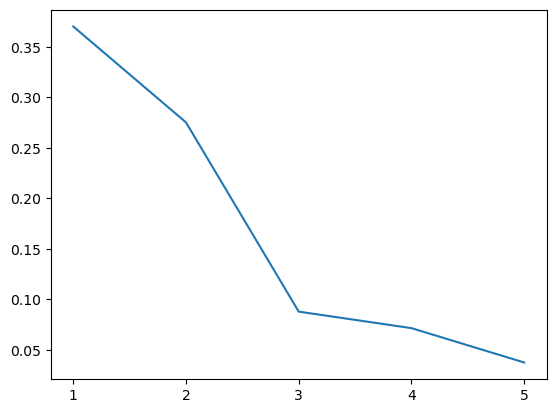

In [101]:
pca = PCA( n_components = 5 )
df = pd.DataFrame( pca.fit_transform( data_robust ) )
var_ratios = dict(zip(range(1, pca.n_components_+1), (pca.explained_variance_ratio_)))
print(var_ratios)
print(f'sum: {sum(var_ratios.values())}')
plt.plot( list(map(str, var_ratios.keys())), var_ratios.values() )
# plt.plot( [ str(i+1) for i in range(5)], pca.explained_variance_ratio_ )
df.head()

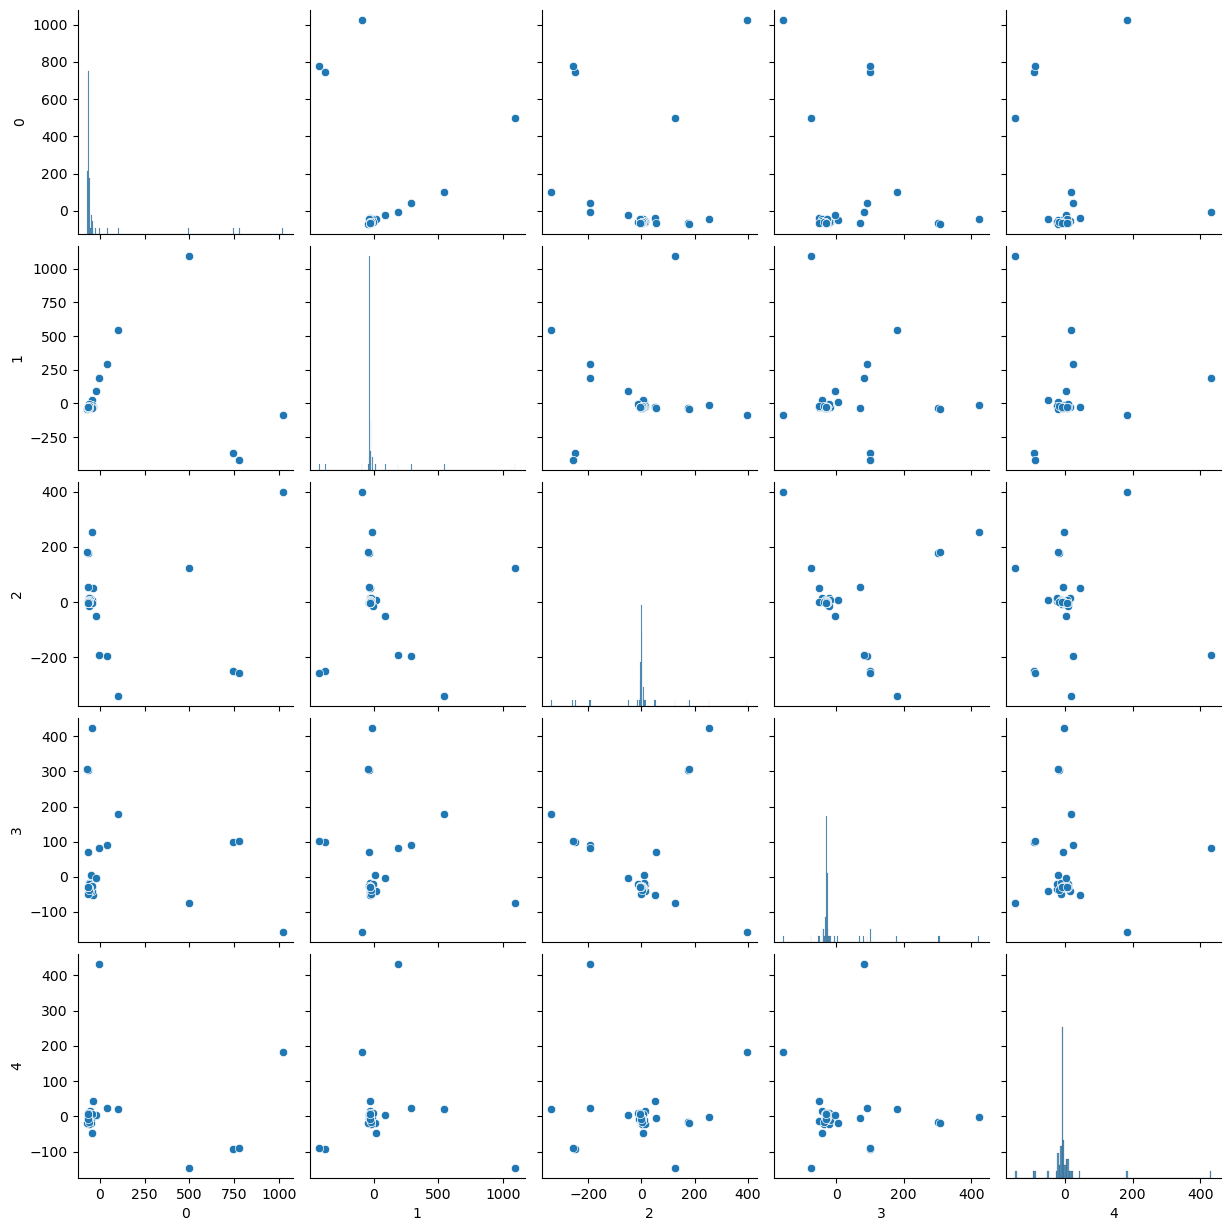

In [103]:
sns.pairplot(df)

In [104]:
Global.folds = enumerate( Global.kfold.split( df, Global.binary_target ) )

run_classifier( df, Global.binary_target, Models.random_forest, 'random_forest', Global.kfold, Global.folds )
run_classifier( df, Global.binary_target, Models.xgboost, 'xgboost', Global.kfold, Global.folds )
run_classifier( df, Global.binary_target, Models.lda, 'lda', Global.kfold, Global.folds )

[random_forest] min: 0.33, max: 0.83, avg 0.63
[xgboost] min: 0.50, max: 0.83, avg 0.70
[lda] min: 0.17, max: 0.83, avg 0.55


In [109]:
features = find_most_important_features( 5 )

25
(12, 5457)
[(338, 0.017338721222504586), (157, 0.017096823316317837), (349, 0.014424373146452842), (377, 0.013656671839795693), (379, 0.013472991204844704)]
Index([338, 157, 349, 377, 379], dtype='int64', name='Patient')


In [133]:
i_features = [x for x,_ in features[:20]]

In [134]:
df = pd.DataFrame(data_robust)[i_features]
print(df.head())
print(df.shape)

       338       157       349       377       379   1208      173       78    \
0 -0.285714  0.096203 -0.090909  2.927536  0.057971  -0.5  0.020478 -0.231651   
1  0.428571  0.339241  0.227273 -0.666667  0.405797   1.0  0.075085  0.772936   
2  0.142857  0.359494 -0.090909 -0.898551 -0.289855   2.0 -0.034130  0.497706   
3  5.857143  1.200000  0.363636  2.463768  0.695652   0.0  0.034130  0.332569   
4  1.428571  0.288608  1.181818  3.391304  1.333333   2.5  0.962457  1.162844   

       589       177      116        35     320       365       723   \
0 -0.177778 -0.015094 -0.03125  -0.050847  0.375 -0.408163  0.137931   
1 -0.177778 -0.030189 -0.03125  14.042373  0.000  7.183673 -0.275862   
2  0.088889 -0.030189 -0.03125   0.805085  0.000  0.081633  0.000000   
3  0.355556  0.045283  4.65625   0.025424  0.750  0.000000  1.793103   
4  1.066667  0.981132  0.84375   1.042373  1.125  0.489796  0.000000   

       43    1210      406   644       256   
0 -0.242424  -1.0  0.301887 -0.15 

In [135]:
Global.folds = enumerate( Global.kfold.split( df, Global.binary_target ) )

run_classifier( df, Global.binary_target, Models.random_forest, 'random_forest', Global.kfold, Global.folds )
run_classifier( df, Global.binary_target, Models.xgboost, 'xgboost', Global.kfold, Global.folds )
run_classifier( df, Global.binary_target, Models.lda, 'lda', Global.kfold, Global.folds )

[random_forest] min: 0.50, max: 1.00, avg 0.85
[xgboost] min: 0.67, max: 1.00, avg 0.85
[lda] min: 0.50, max: 1.00, avg 0.78
